**1. Inicializar y cargar el contexto spark**

In [260]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql.functions import col, avg, desc, sum

**2. Número de países distintos en cada dataset. Coinciden?**

Antes de comenzar vamos a proceder a hacer la carga de datos en pyspark

In [227]:
from google.colab import files
files.upload()

Saving indicadores_desarrollo.csv to indicadores_desarrollo (1).csv
Saving indicadores_deuda.csv to indicadores_deuda (1).csv


{'indicadores_desarrollo.csv': b'country_name,country_code,anho,GC.DOD.TOTL.CN,GC.DOD.TOTL.GD.ZS,SP.DYN.CBRT.IN\r\nAlbania,ALB,2014 [YR2014],1023040800000,73.3202469198429,12.259\r\nAlbania,ALB,2015 [YR2015],1145500940000,79.8644448747259,12.197\r\nAlbania,ALB,2016 [YR2016],1188814490000,80.7355748396923,12.08\r\nAustralia,AUS,2014 [YR2014],674700000,0.042207528166503,13.2\r\nAustralia,AUS,2015 [YR2015],762718000,0.0469480198522591,12.9\r\nAustralia,AUS,2016 [YR2016],907555000,0.054648482520169,12.9\r\n"Bahamas, The",BHS,2014 [YR2014],5158420000,47.2672793747079,14.34\r\n"Bahamas, The",BHS,2015 [YR2015],5655150000,48.1195170307089,14.224\r\n"Bahamas, The",BHS,2016 [YR2016],6138814000,51.4207431481606,14.131\r\nBarbados,BRB,2014 [YR2014],12175704025,129.629591844133,10.916\r\nBarbados,BRB,2015 [YR2015],13365027241,141.413895259761,10.806\r\nBelarus,BLR,2014 [YR2014],19781184418,24.5487262642116,12.5\r\nBelarus,BLR,2015 [YR2015],33804450453.3197,37.5981780556757,12.5\r\nBelarus,BLR,2016 

In [230]:
# Cargamos los datos y hacemos una previsualizacion de los mismos
desarrollo_raw = sc.textFile("indicadores_desarrollo.csv")
deuda_raw = sc.textFile("indicadores_deuda.csv")
desarrollo_raw.take(5)
deuda_raw.take(5)

['country_name,country_code,DT.AMT.BLAT.CD,DT.AMT.DLXF.CD,DT.AMT.DPNG.CD,DT.AMT.MLAT.CD,DT.AMT.OFFT.CD,DT.AMT.PBND.CD,DT.AMT.PCBK.CD,DT.AMT.PROP.CD,DT.AMT.PRVT.CD,DT.DIS.BLAT.CD,DT.DIS.DLXF.CD,DT.DIS.MLAT.CD,DT.DIS.OFFT.CD,DT.DIS.PCBK.CD,DT.DIS.PROP.CD,DT.DIS.PRVT.CD,DT.INT.BLAT.CD,DT.INT.DLXF.CD,DT.INT.DPNG.CD,DT.INT.MLAT.CD,DT.INT.OFFT.CD,DT.INT.PBND.CD,DT.INT.PCBK.CD,DT.INT.PROP.CD,DT.INT.PRVT.CD',
 'Afghanistan,AFG,61739336.9,100847181.9,,39107845,100847181.9,,,,,49114729.4,72894453.7,23779724.3,72894453.7,,,,39903620.1,53239440.1,,13335820,53239440.1,,,,',
 'Albania,ALB,54250280.6,790248675.2,514185620,182197616.7,236447897.3,0,39445139.5,170018.4,39615157.9,76050616.1,317194512.5,234321242.3,310371858.4,4542664.9,2279989.2,6822654.1,13847333.6,165602386.9,87884000,28101536.1,41948869.7,31030688.2,4618504.3,120324.7,35769517.2',
 'Algeria,DZA,95188724.6,171185188.1,75420000,0,95188724.6,,576463.5,0,576463.5,10320772.2,10320772.2,,10320772.2,,,,7680627.6,19031728.7,3220000,8094779,

Como podemos observar, los datos tienen un header, que vamos a quitar para poder operar comodamente

In [266]:
# Primero le quitamos el header a desarrollo
header_desarrollo = desarrollo_raw.first()
desarrollo = desarrollo_raw.filter(lambda x: x !=header_desarrollo)
desarrollo.take(10)

# Ahora hacemos lo mismo con deuda
header_deuda = deuda_raw.first()
deuda = deuda_raw.filter(lambda x: x != header_deuda)
deuda.take(5)

['Afghanistan,AFG,61739336.9,100847181.9,,39107845,100847181.9,,,,,49114729.4,72894453.7,23779724.3,72894453.7,,,,39903620.1,53239440.1,,13335820,53239440.1,,,,',
 'Albania,ALB,54250280.6,790248675.2,514185620,182197616.7,236447897.3,0,39445139.5,170018.4,39615157.9,76050616.1,317194512.5,234321242.3,310371858.4,4542664.9,2279989.2,6822654.1,13847333.6,165602386.9,87884000,28101536.1,41948869.7,31030688.2,4618504.3,120324.7,35769517.2',
 'Algeria,DZA,95188724.6,171185188.1,75420000,0,95188724.6,,576463.5,0,576463.5,10320772.2,10320772.2,,10320772.2,,,,7680627.6,19031728.7,3220000,8094779,15775406.6,,13192.3,23129.8,36322.1',
 'Angola,AGO,8473824016.3,11067045628.1,,124688691.9,8598512708.2,1e+09,1125088719.9,343444200,2468532919.9,8838256901.1,10924018093.1,178989598.2,9017246499.3,1906771593.8,,1906771593.8,1005053965.1,1798550445.5,,47038476.1,1052092441.2,7e+07,580902004.3,95556000,746458004.3',
 'Armenia,ARM,68968314.7,845630723.8,680696190,94331207.1,163299521.8,0,1635012,,1635012

A continuación procedemos a hacer el parseado de los datos tanto para deuda como para desarrollo.
En general, tanto para deuda como para desarrollo nos va a interesar:


*   Eliminar las comas de los nombres de paises para que al separar por comas no den problemas
*   Separar por comas
*   Pasar los datos numéricos a float





In [267]:
# Parseado desarrollo
def parseado_desarrollo(x):
  if '"' in x:
    line = [x.split('",')[0] + '"'] + x.split('",')[1].split(',')
  else:
    line = x.split(',')
  return line

desarrollo = desarrollo.map(parseado_desarrollo)
desarrollo.take(10)

[['Albania',
  'ALB',
  '2014 [YR2014]',
  '1023040800000',
  '73.3202469198429',
  '12.259'],
 ['Albania',
  'ALB',
  '2015 [YR2015]',
  '1145500940000',
  '79.8644448747259',
  '12.197'],
 ['Albania',
  'ALB',
  '2016 [YR2016]',
  '1188814490000',
  '80.7355748396923',
  '12.08'],
 ['Australia',
  'AUS',
  '2014 [YR2014]',
  '674700000',
  '0.042207528166503',
  '13.2'],
 ['Australia',
  'AUS',
  '2015 [YR2015]',
  '762718000',
  '0.0469480198522591',
  '12.9'],
 ['Australia',
  'AUS',
  '2016 [YR2016]',
  '907555000',
  '0.054648482520169',
  '12.9'],
 ['"Bahamas, The"',
  'BHS',
  '2014 [YR2014]',
  '5158420000',
  '47.2672793747079',
  '14.34'],
 ['"Bahamas, The"',
  'BHS',
  '2015 [YR2015]',
  '5655150000',
  '48.1195170307089',
  '14.224'],
 ['"Bahamas, The"',
  'BHS',
  '2016 [YR2016]',
  '6138814000',
  '51.4207431481606',
  '14.131'],
 ['Barbados',
  'BRB',
  '2014 [YR2014]',
  '12175704025',
  '129.629591844133',
  '10.916']]

In [233]:
# Parseado deuda
def parseado_deuda(x):
  if '"' in x:
    line = [x.split('",')[0] + '"'] + x.split('",')[1].split(',')
  else:
    line = x.split(',')
  return line

deuda = deuda.map(parseado_deuda)
deuda.take(10)

[['Afghanistan',
  'AFG',
  '61739336.9',
  '100847181.9',
  '',
  '39107845',
  '100847181.9',
  '',
  '',
  '',
  '',
  '49114729.4',
  '72894453.7',
  '23779724.3',
  '72894453.7',
  '',
  '',
  '',
  '39903620.1',
  '53239440.1',
  '',
  '13335820',
  '53239440.1',
  '',
  '',
  '',
  ''],
 ['Albania',
  'ALB',
  '54250280.6',
  '790248675.2',
  '514185620',
  '182197616.7',
  '236447897.3',
  '0',
  '39445139.5',
  '170018.4',
  '39615157.9',
  '76050616.1',
  '317194512.5',
  '234321242.3',
  '310371858.4',
  '4542664.9',
  '2279989.2',
  '6822654.1',
  '13847333.6',
  '165602386.9',
  '87884000',
  '28101536.1',
  '41948869.7',
  '31030688.2',
  '4618504.3',
  '120324.7',
  '35769517.2'],
 ['Algeria',
  'DZA',
  '95188724.6',
  '171185188.1',
  '75420000',
  '0',
  '95188724.6',
  '',
  '576463.5',
  '0',
  '576463.5',
  '10320772.2',
  '10320772.2',
  '',
  '10320772.2',
  '',
  '',
  '',
  '7680627.6',
  '19031728.7',
  '3220000',
  '8094779',
  '15775406.6',
  '',
  '13192.3'

Ahora que ya tenemos los datos parseados, podemos comenzar a operar con ellos.
Vamos a obtener los distintos paises presentes en ambos datasets.

In [234]:
# Para desarrollo:
paises_desarrollo = desarrollo.map(lambda x: x[0]).distinct()
paises_desarrollo.collect()        # Ejecutando esta linea de código obtendríamos 
                                   # un listado con los distintos paises en el dataset desarrollo

total_paises_desarrollo = len(paises_desarrollo.collect())
print(f'El total de paises distintos en el dataset de desarrollo es {total_paises_desarrollo}')

# Para deuda:
paises_deuda = deuda.map(lambda x: x[0]).distinct()
paises_deuda.collect()             # Ejecutando esta linea de código obtendríamos 
                                   # un listado con los distintos paises en el dataset deuda

total_paises_deuda = len(paises_deuda.collect())
print(f'El total de paises distintos en el dataset de deuda es {total_paises_deuda}')

El total de paises distintos en el dataset de desarrollo es 51
El total de paises distintos en el dataset de deuda es 124


Coinciden?

In [302]:
diferencia = total_paises_deuda-total_paises_desarrollo
print("La diferencia entre el número de paises en deuda y el número de paises en desarrollo es de {}.".format(diferencia))

La diferencia entre el número de paises en deuda y el número de paises en desarrollo es de 73.


**3. Total de deuda contraida por cada pais: total amount of debt (in USD) DT.AMT.MLAT.CD**

*  Primero aplicamos una función lambda a cada linea para seleccionar el nombre del pais y la deuda (como float para poder operar con reducebykey)
*  Despues al objeto creado anteriormente le aplicamos una funcion reducebykey para que en base a la key (pais) nos sume toda su deuda
*  Para poder ver el resultado utilizamos collect(), ya que solo a través de las acciones tienen lugar las computaciones en Spark





In [247]:
deuda_pais = deuda.\
map(lambda x: (x[0], float(x[5]))).\
reduceByKey(lambda x, y: x + y)

deuda_pais.collect()

[('Albania', 182197616.7),
 ('Algeria', 0.0),
 ('Angola', 124688691.9),
 ('Belize', 29683326.5),
 ('Bhutan', 17390420.5),
 ('Botswana', 125652344.5),
 ('Brazil', 2514318741.6),
 ('Cabo Verde', 39970124.9),
 ('Cambodia', 72307001.8),
 ('China', 2615723714.1),
 ('"Congo, Dem. Rep."', 143105462.0),
 ('Costa Rica', 272808260.7),
 ("Cote d'Ivoire", 84629406.5),
 ('Ecuador', 578894793.9),
 ('El Salvador', 298939687.1),
 ('Eritrea', 15482475.4),
 ('Ethiopia', 171590722.7),
 ('Fiji', 9082442.6),
 ('Gabon', 62404132.3),
 ('Ghana', 130202003.1),
 ('Guatemala', 339822253.6),
 ('Guinea-Bissau', 6713257.2),
 ('Honduras', 148225048.7),
 ('India', 4545609909.9),
 ('Kazakhstan', 1079948889.7),
 ('Kenya', 391340889.9),
 ('Kosovo', 33590154.6),
 ('Kyrgyz Republic', 75278037.2),
 ('Least developed countries: UN classification', 4084275524.2),
 ('Lebanon', 167638089.7),
 ('Liberia', 7383619.4),
 ('"Macedonia, FYR"', 185952867.2),
 ('Malawi', 35659831.4),
 ('Maldives', 17896143.5),
 ('Mauritania', 18440822

**4. Media de los indicadores de deuda (tabla uno): DT.AMT.BLAT.CD, DT.DIS.BLAT.CD, DT.INT.BLAT.CD**

Antes de nada vamos a pasar deuda a DataFrame ya que consideramos que en este caso resultará mucho más cómodo para el objeto del ejercicio. Además, vamos a reemplazar los puntos de los títulos del header por espacios ya que hemos visto que la función toDF presenta un bug al introducir puntos. Para evitar problemas los quitamos.

In [253]:
df_deuda = deuda.toDF([x.replace('.', ' ') for x in header_deuda.split(",")])
df_deuda.show()

+--------------------+------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|        country_name|country_code|DT AMT BLAT CD|DT AMT DLXF CD|DT AMT DPNG CD|DT AMT MLAT CD|DT AMT OFFT CD|DT AMT PBND CD|DT AMT PCBK CD|DT AMT PROP CD|DT AMT PRVT CD|DT DIS BLAT CD|DT DIS DLXF CD|DT DIS MLAT CD|DT DIS OFFT CD|DT DIS PCBK CD|DT DIS PROP CD|DT DIS PRVT CD|DT INT BLAT CD|DT INT DLXF CD|DT INT DPNG CD|DT INT MLAT CD|DT INT OFFT CD|DT INT PBND CD|DT INT PCBK CD|DT INT PROP CD|DT INT PRVT CD|
+--------------------+------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------

A continuación procedemos a renombrar las variables con las que vamos a estar tratando para mejor comprensión y aplicamos la función media a cada una de ellas.

In [278]:
rename_df_deuda = df_deuda.withColumnRenamed("DT AMT BLAT CD", "PPG_bilateral_AMT").\
withColumnRenamed("DT DIS BLAT CD", "PPG_bilateral_DIS").\
withColumnRenamed("DT INT BLAT CD", "PPG_bilateral_INT")

rename_df_deuda.select(avg("PPG_bilateral_AMT"), avg("PPG_bilateral_DIS"), avg("PPG_bilateral_INT")).show()


+----------------------+----------------------+----------------------+
|avg(PPG_bilateral_AMT)|avg(PPG_bilateral_DIS)|avg(PPG_bilateral_INT)|
+----------------------+----------------------+----------------------+
|   7.126196346598358E8|  1.2231392903982306E9|  1.6409328560901642E8|
+----------------------+----------------------+----------------------+



**5. Los 20 paises con DT.AMT.DLXF.CD más alto**

Seleccionamos por un lado la variable pais que nos va a permitir más adelante agrupar en base a ella y por otro la variable DT.AMT.DLXF.CD que nos va a proporcionar el datos que nos interesa para después ordenarlos de mayor a menor y quedarnos con los 20 mayores.

In [ ]:
paises_DTAMTDLXFCD_20 = deuda.\
map(lambda x: (x[0], float(x[3]))).\
reduceByKey(lambda x, y: x + y).\
takeOrdered(20, lambda x: -x[1])

paises_DTAMTDLXFCD_20

[('China', 96218620835.7),
 ('Brazil', 90041840304.1),
 ('Russian Federation', 66589761833.5),
 ('Turkey', 51555031005.8),
 ('South Asia', 48756295898.2),
 ('India', 31923507000.8),
 ('Indonesia', 30916112653.8),
 ('Kazakhstan', 27482093686.4),
 ('Mexico', 25218503927.0),
 ('Least developed countries: UN classification', 25197029299.4),
 ('IDA only', 20483289208.0),
 ('Romania', 14013783350.4),
 ('Colombia', 11985674438.7),
 ('Angola', 11067045628.1),
 ('Cameroon', 10404814960.2),
 ('"Venezuela, RB"', 9878659207.2),
 ('"Egypt, Arab Rep."', 9692114176.9),
 ('Lebanon', 9506919669.6),
 ('South Africa', 9474257551.9),
 ('Vietnam', 8873505909.2)]

**6. Pais con los datos informados todos los años.**

Por un lado tendremos que averigual el número de años distintos que hay para saber que paises tienen datos todos los años. 

In [ ]:
# Averiguamos el número de años distintos
paises_desarrollo = desarrollo.\
map(lambda x: x[2]).distinct()

paises_desarrollo.collect() # Existen 4 años distintos

['2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]']

Ahora procedemos a contar el número de años distintos en los que cada pais tiene observaciones y nos quedamos solo con aquellos que tengan 4 observaciones, ya que esto significará que tienen observaciones en todos los años.



1.   Seleccionamos las dos columnas que nos interesan con map (año y pais)
2.   Agrupamos el resultado anterior por clave
3.   A partir del resultado anterior volvemos a seleccionar la columna de pais y además hacemos un conteo de la columna año 
4.   Filtramos el resultado anterior para quedarnos solamente con aquellos que cunplan que el numero de años es 4





In [ ]:
años_pais = desarrollo.\
map(lambda x: (x[0], x[2])).\
groupByKey().\
map(lambda x: (x[0], len(x[1]))).\
filter(lambda x: x[1] == 4)

años_pais.collect() # Únicamente Malawi tiene datos informados todos los años


[('Malawi', 4)]

**7. Media anual de los distintos indicadores de desarrollo**

De nuevo prodecemos a convertir nuestros datos a DataFrame, este caso para desarrollo, ya que consideramos que en este caso resultará mucho más cómodo para el objeto del ejercicio. Además, vamos a reemplazar los puntos de los títulos del header por espacios ya que hemos visto que la función toDF presenta un bug al introducir puntos. Para evitar problemas los quitamos.

In [270]:
df_desarrollo = desarrollo.toDF([x.replace('.', ' ') for x in header_desarrollo.split(",")])
df_desarrollo.show()

+--------------+------------+-------------+----------------+------------------+--------------+
|  country_name|country_code|         anho|  GC DOD TOTL CN| GC DOD TOTL GD ZS|SP DYN CBRT IN|
+--------------+------------+-------------+----------------+------------------+--------------+
|       Albania|         ALB|2014 [YR2014]|   1023040800000|  73.3202469198429|        12.259|
|       Albania|         ALB|2015 [YR2015]|   1145500940000|  79.8644448747259|        12.197|
|       Albania|         ALB|2016 [YR2016]|   1188814490000|  80.7355748396923|         12.08|
|     Australia|         AUS|2014 [YR2014]|       674700000| 0.042207528166503|          13.2|
|     Australia|         AUS|2015 [YR2015]|       762718000|0.0469480198522591|          12.9|
|     Australia|         AUS|2016 [YR2016]|       907555000| 0.054648482520169|          12.9|
|"Bahamas, The"|         BHS|2014 [YR2014]|      5158420000|  47.2672793747079|         14.34|
|"Bahamas, The"|         BHS|2015 [YR2015]|      5

Para terminar, realizamos un groupBy() sobre la columna año y calculamos la media de las variables que nos interesan con la función avg(). De esta manera obtenemos la media por indicador para cada año.

In [277]:
rename_df_desarrollo = df_desarrollo.withColumnRenamed("anho", "year").\
withColumnRenamed("GC DOD TOTL CN", "gob_debt_LCU").\
withColumnRenamed("GC DOD TOTL GD ZS", "gob_debt_per").\
withColumnRenamed("SP DYN CBRT IN", "birth_rate")

rename_df_desarrollo.groupBy("year").agg(avg("gob_debt_LCU"), avg("gob_debt_per"), avg("birth_rate")).show()

+-------------+--------------------+------------------+------------------+
|         year|   avg(gob_debt_LCU)| avg(gob_debt_per)|   avg(birth_rate)|
+-------------+--------------------+------------------+------------------+
|2016 [YR2016]|1.588138215480659...|58.796949624008356|16.144333333333332|
|2014 [YR2014]|1.034427587329532...|56.843914344384395|17.582620000000006|
|2017 [YR2017]| 2.23985861996269E12|   48.659564238322|            34.593|
|2015 [YR2015]|1.318244039159025E14| 58.36559834488034|16.798477272727272|
+-------------+--------------------+------------------+------------------+



**8. Podrías decirme el total de deuda acumulada DT.AMT.MLAT.CD por los 10 países con un valor en media menor de SP.DYN.CBRT.IN**

Puesto que en este caso las variables con las que nos interesa operar se encuentran en datasets distintos, vamos a proceder a realizar una unión de los mismos.

In [281]:
data_union = df_desarrollo.join(other=df_deuda, on=["country_code", "country_name"], how="inner")
data_union.show(2)

+------------+------------+-------------+--------------+-----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|country_code|country_name|         anho|GC DOD TOTL CN|GC DOD TOTL GD ZS|SP DYN CBRT IN|DT AMT BLAT CD|DT AMT DLXF CD|DT AMT DPNG CD|DT AMT MLAT CD|DT AMT OFFT CD|DT AMT PBND CD|DT AMT PCBK CD|DT AMT PROP CD|DT AMT PRVT CD|DT DIS BLAT CD|DT DIS DLXF CD|DT DIS MLAT CD|DT DIS OFFT CD|DT DIS PCBK CD|DT DIS PROP CD|DT DIS PRVT CD|DT INT BLAT CD|DT INT DLXF CD|DT INT DPNG CD|DT INT MLAT CD|DT INT OFFT CD|DT INT PBND CD|DT INT PCBK CD|DT INT PROP CD|DT INT PRVT CD|
+------------+------------+-------------+--------------+--------------

A continuación, pasamos a seleccionar las variables con las que nos interesa trabajar (nomber del país, deuda acumulada y tasa de nacimientos).

In [283]:
debt_birth_select = data_union.select("country_name", "DT AMT MLAT CD", "SP DYN CBRT IN")
debt_birth_select.show()

+---------------+--------------+--------------+
|   country_name|DT AMT MLAT CD|SP DYN CBRT IN|
+---------------+--------------+--------------+
|        Jamaica|     174427648|        16.814|
|        Jamaica|     174427648|        16.633|
|        Jamaica|     174427648|         16.46|
|Kyrgyz Republic|    75278037.2|          27.7|
|Kyrgyz Republic|    75278037.2|          27.4|
|Kyrgyz Republic|    75278037.2|            26|
|       Colombia|  1100907553.6|        15.725|
|       Colombia|  1100907553.6|        15.515|
|       Colombia|  1100907553.6|        15.308|
|    Philippines|   739056427.3|        22.935|
|      Sri Lanka|   449771961.1|        16.849|
|      Sri Lanka|   449771961.1|        16.609|
|        Albania|   182197616.7|        12.259|
|        Albania|   182197616.7|        12.197|
|        Albania|   182197616.7|         12.08|
|         Brazil|  2514318741.6|        14.624|
|         Brazil|  2514318741.6|        14.472|
|         Brazil|  2514318741.6|        

Observamos que en la tabla anterior hay paises repetidos debido a que tenemos datos de distintos años. Vamos a proceder a agrupar la tabla anterior por pais y a calcular la media de la tasa de natalidad.

In [286]:
data_birth_mean = debt_birth_select.groupBy("country_name", "DT AMT MLAT CD").agg(avg("SP DYN CBRT IN"))
data_birth_mean.show()

+------------------+--------------+-------------------+
|      country_name|DT AMT MLAT CD|avg(SP DYN CBRT IN)|
+------------------+--------------+-------------------+
|         Guatemala|   339822253.6| 25.628666666666664|
|            Bhutan|    17390420.5|             17.791|
|         St. Lucia|    15019216.3|             12.502|
|           Moldova|   135842865.5| 10.604333333333335|
|             Tonga|     2791253.2| 25.362333333333336|
|           Jamaica|     174427648|  16.63566666666667|
|   Kyrgyz Republic|    75278037.2|  27.03333333333333|
|          Colombia|  1100907553.6|             15.516|
|          Botswana|   125652344.5| 26.417666666666666|
|       El Salvador|   298939687.1| 18.733999999999998|
|  Papua New Guinea|      78345326|            28.1685|
|            Jordan|   270498715.5|             24.305|
|            Malawi|    35659831.4|             35.556|
|   Solomon Islands|     3952828.9| 33.525666666666666|
|              Peru|     553634090| 18.564666666

A continuación ordenamos por orden de menor a mayor la tasa de natalidad para quedarnos con los 10 paises con menor tasa de natalidad y después poder realizar la suma del total de deuda para dichos paises.

In [287]:
data_birth_order = data_birth_mean.sort("avg(SP DYN CBRT IN)").limit(10)
data_birth_order.show()

+--------------------+--------------+-------------------+
|        country_name|DT AMT MLAT CD|avg(SP DYN CBRT IN)|
+--------------------+--------------+-------------------+
|             Ukraine|  1072472830.3|               10.6|
|             Moldova|   135842865.5| 10.604333333333335|
|            Thailand|    39071571.5|            10.9175|
|             Albania|   182197616.7| 12.178666666666667|
|             Belarus|     595438826| 12.466666666666667|
|           St. Lucia|    15019216.3|             12.502|
|  Russian Federation|     141669500| 13.166666666666666|
|             Georgia|   144062401.5|             14.056|
|              Brazil|  2514318741.6| 14.467666666666666|
|St. Vincent and t...|    21615600.7|             15.011|
+--------------------+--------------+-------------------+



Finalmente realizamos la suma del total de deuda de los 10 paises con menor tasa de natalidad.

In [290]:
sum_debt_minbirth = data_birth_order.select(sum("DT AMT MLAT CD")).show()

+-------------------+
|sum(DT AMT MLAT CD)|
+-------------------+
|4.861709170099999E9|
+-------------------+



**9. ¿Hay alguna relación entre los nacimientos y el indicador DT.AMT.DLXF.CD? ¿Cómo podrías demostrarlo?**

Puesto que de nuevo las variables con las que nos interesa trabajar están en datasets distintos, recurrimos al dataset que habíamos unido anteriormente "data_union" y seleccionamos las variables que nos interesan (nombre del pais, indicador y tasa de natalidad).

In [294]:
rel_birth_debt = data_union.select("country_name", "DT AMT DLXF CD", "SP DYN CBRT IN").\
groupBy("country_name", "DT AMT DLXF CD").agg(avg("SP DYN CBRT IN"))

rel_birth_debt.show()

+--------------------+--------------+-------------------+
|        country_name|DT AMT DLXF CD|avg(SP DYN CBRT IN)|
+--------------------+--------------+-------------------+
|    Papua New Guinea|  2842193842.5|            28.1685|
|     Kyrgyz Republic|   816419045.1|  27.03333333333333|
|             Belarus|  4640037884.2| 12.466666666666667|
|         Philippines|  6479170917.7|             22.935|
|              Turkey| 51555031005.8| 16.717333333333332|
|          Kazakhstan| 27482093686.4| 22.776666666666667|
|            Colombia| 11985674438.7|             15.516|
|St. Vincent and t...|    26411052.2|             15.011|
|                Peru|  5881259974.7| 18.564666666666668|
|           St. Lucia|    20332673.8|             12.502|
|             Jamaica|   559597431.4|  16.63566666666667|
|               Tonga|    10369910.6| 25.362333333333336|
|           Guatemala|  2911981987.8| 25.628666666666664|
|             Moldova|     769232867| 10.604333333333335|
|         El S

Por último vamos a averiguar si hay algún tipo de relación entre las dos variables que nos interesan.

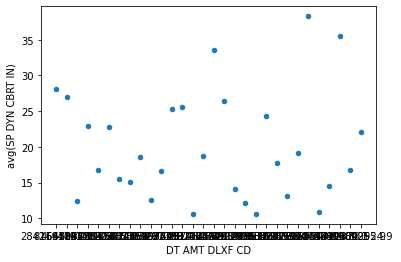

In [297]:
# Importamos pandas
import pandas as pd
# Para poder representar necesitamos que los datos a representar estén pasados a formato pandas
pandas_data = rel_birth_debt.toPandas()
# Representamos
pandas_data.plot.scatter(x="DT AMT DLXF CD", y="avg(SP DYN CBRT IN)");

En principio no existe relación aparente entre la tasa de natalidad y el indicador DT.AMT.DLXF.CD.